In [1]:
import numpy as np
import torch
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

**Environment**

In [2]:
class NeuralBandit:
    def __init__(self, state_dim, num_action, reward_model):
        self.state_dim = state_dim
        self.num_action = num_action
        self.reward_model = reward_model
    
    @torch.no_grad()
    def get_reward(self, states, actions):
        actions_oh = torch.nn.functional.one_hot(actions, self.num_action)
        return self.reward_model(states, actions_oh).squeeze(1)  # [batch]
    
    def get_state(self, n=1):
        return torch.rand(n, self.state_dim) * 2 - 1
    
    def optimal_policy(self, states):  # states: [batch, state_dim]
        actions = torch.arange(self.num_action).repeat(states.shape[0])
        states = torch.repeat_interleave(states, self.num_action, 0)
        rewards = self.get_reward(states, actions).reshape(-1, self.num_action)  # [batch, num_action]
        pi = torch.nn.functional.one_hot(rewards.argmax(dim=1), self.num_action).float()
        return pi
    
    def evaluate_policy(self, policy, times=5000):
        states = self.get_state(times)
        pi = policy(states)  # pi: [times, num_action]
        rewards = torch.zeros(times, self.num_action)
        for action in range(self.num_action):
            rewards[:, action] = self.get_reward(states, torch.full((times,), action))
        return (rewards * pi).sum(dim=1).mean().item()

**Models**

In [3]:
class RewardModel(torch.nn.Module):
    def __init__(self, state_dim, num_action, is_env=True, hidden_dim=64):
        super().__init__()
        self.state_embedding = torch.nn.Sequential(
            torch.nn.Linear(state_dim, hidden_dim), 
            torch.nn.Tanh()) if is_env else torch.nn.Sequential(
            torch.nn.Linear(state_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU())
        self.action_embedding = torch.nn.Sequential(
            torch.nn.Linear(num_action, hidden_dim), 
            torch.nn.Tanh()) if is_env else torch.nn.Sequential(
            torch.nn.Linear(num_action, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU())
        self.reward_layer = torch.nn.Linear(2 * hidden_dim, 1)
        self.is_env = is_env
    
    def forward(self, states, actions):
        states = states.to(device)
        actions = actions.float().to(device)
        state_embed = self.state_embedding(states)
        action_embed = self.action_embedding(actions)
        hidden_state = torch.cat([state_embed, action_embed], dim=1)
        rewards = self.reward_layer(hidden_state)
        if self.is_env:    
            rewards = rewards + torch.sign(rewards)  # Further distinguish advantages and disadvantages
        return rewards
    

class PolicyModel(torch.nn.Module):
    def __init__(self, state_dim, num_action, hidden_dim=64, is_ref=False):
        super().__init__()
        self.state_embedding = torch.nn.Sequential(
            torch.nn.Linear(state_dim, hidden_dim), 
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU()) if not is_ref else None
        self.action_layer = torch.nn.Linear(hidden_dim, num_action) if not is_ref else None
        self.is_ref = is_ref
        self.num_action = num_action
    
    def forward(self, states):
        if self.is_ref:
            with torch.no_grad():
                return torch.softmax(torch.zeros(states.shape[0], self.num_action).to(device), dim=-1)
        states = states.to(device)
        state_embed = self.state_embedding(states)
        pi = torch.softmax(self.action_layer(state_embed), dim=-1)
        return pi

**Optimization Methods**

In [4]:
def collect_preference_data(env, num_pref_data):
    datasets = []
    for i in range(num_pref_data):
        state = env.get_state(1)
        a1, a2 = np.random.choice(env.num_action, 2, replace=False)
        a1 = torch.tensor([a1])
        a2 = torch.tensor([a2])

        r1 = env.get_reward(state, a1)[0]
        r2 = env.get_reward(state, a2)[0]
        prob = torch.exp(r1) / (torch.exp(r2) + torch.exp(r1))  # Bradley-Terry model
        prob = prob.item()
        if np.random.random() < prob:
            datasets.append([state, a1, a2])
        else:
            datasets.append([state, a2, a1])
    return datasets

def dpo(model, ref, env, pref_data, lr=1e-3, beta=1.0, batch_size=64, epochs=100, clip=1):
    optimal_reward = env.evaluate_policy(env.optimal_policy)
    train_loss = []
    reward_gap = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(epochs):
        total_loss = 0
        k = 0
        for j in range(0, len(pref_data), batch_size):
            batch = pref_data[j:j+batch_size]
            states = torch.cat([data[0] for data in batch], dim=0)
            a_chosen = torch.cat([data[1] for data in batch], dim=0).unsqueeze(1)
            a_reject = torch.cat([data[2] for data in batch], dim=0).unsqueeze(1)
            pi = model(states)  # pi: [batch, num_action]
            pi_ref = ref(states)
            pi = torch.clamp(pi, 1e-8, 1-1e-8)  # Avoid log(0)
            chosen_logprob = torch.log(pi.gather(1, a_chosen)).squeeze(1)
            reject_logprob = torch.log(pi.gather(1, a_reject)).squeeze(1)
            chosen_refprob = torch.log(pi_ref.gather(1, a_chosen)).squeeze(1)
            reject_refprob = torch.log(pi_ref.gather(1, a_reject)).squeeze(1)
            chosen_logratio = chosen_logprob - chosen_refprob
            reject_logratio = reject_logprob - reject_refprob
            loss = -torch.nn.functional.logsigmoid(beta * (chosen_logratio - reject_logratio)).mean()
            optimizer.zero_grad()
            total_loss += loss.item()
            k += 1
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        with torch.no_grad():
            reward = env.evaluate_policy(model)
        train_loss.append(total_loss / k)
        reward_gap.append(optimal_reward - reward)
    return train_loss, reward_gap


def reward_training(reward_model, pref_data, env, lr=1e-3, batch_size=64, epochs=100, num_err=1000):
    train_loss = []
    train_acc = []
    optimizer = torch.optim.Adam(reward_model.parameters(), lr=lr)
    for i in range(epochs):
        total_loss = 0
        total_acc = 0
        k = 0
        for j in range(0, len(pref_data), batch_size):
            batch = pref_data[j:j+batch_size]
            states = torch.cat([data[0] for data in batch], dim=0)
            a_chosen = torch.nn.functional.one_hot(torch.cat([data[1] for data in batch], dim=0), env.num_action)
            a_reject = torch.nn.functional.one_hot(torch.cat([data[2] for data in batch], dim=0), env.num_action)
            chosen_rewards = reward_model(states, a_chosen)
            reject_rewards = reward_model(states, a_reject)
            loss = -torch.log(torch.sigmoid(chosen_rewards - reject_rewards)).mean()
            optimizer.zero_grad()
            total_loss += loss.item()
            total_acc += (chosen_rewards > reject_rewards).float().mean().item()
            k += 1
            loss.backward()
            optimizer.step()
        train_loss.append(total_loss / k)
        train_acc.append(total_acc / k)
    with torch.no_grad():
        reward_tau = torch.zeros(num_err)
        states = env.get_state(num_err)
        states = torch.repeat_interleave(states, env.num_action, dim=0)
        actions = torch.arange(env.num_action).repeat(num_err)
        true_rewards = env.get_reward(states, actions).reshape(num_err, env.num_action)
        actions_oh = torch.nn.functional.one_hot(actions, env.num_action)
        pred_rewards = reward_model(states, actions_oh).reshape(num_err, env.num_action)
        for i, (t, p) in enumerate(zip(true_rewards, pred_rewards)):
            reward_tau[i] = kendalltau(t.cpu(), p.cpu()).correlation
        reward_tau = reward_tau.mean().item()
    return train_loss, train_acc, reward_tau


def pg(policy_model, reward_model, ref_model, env, pref_data, lr=1e-3, beta=1.0, batch_size=64, epochs=100, clip=1):
    optimal_reward = env.evaluate_policy(env.optimal_policy)
    train_loss = []
    reward_gap = []
    optimizer = torch.optim.Adam(policy_model.parameters(), lr=lr)
    for i in range(epochs):
        total_loss = 0
        k = 0
        for j in range(0, len(pref_data), batch_size):
            states = env.get_state(batch_size)
            pi = policy_model(states)  # pi: [batch, num_action]
            pi_ref = ref_model(states)
            actions = torch.arange(env.num_action).repeat(batch_size)
            actions_oh = torch.nn.functional.one_hot(actions, env.num_action)
            states = torch.repeat_interleave(states, env.num_action, dim=0)
            with torch.no_grad():
                rewards = reward_model(states, actions_oh).reshape(batch_size, env.num_action)
                kl = torch.log(pi) - torch.log(pi_ref)
                rewards = rewards - beta * kl
            loss = -torch.sum(pi * rewards, dim=-1).mean()
            optimizer.zero_grad()
            total_loss += loss.item()
            k += 1
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_model.parameters(), clip)
            optimizer.step()
        with torch.no_grad():
            reward = env.evaluate_policy(policy_model)
        train_loss.append(total_loss / k)
        reward_gap.append(optimal_reward - reward)
    policy_model.eval()
    return train_loss, reward_gap

**Convergence Experiments**

In [5]:
state_dim = 50
num_action = 10
hidden_dim = 64
pref_data_size = 100
reward_epochs = 50
policy_epochs = 250
batch_size = 64
learning_rate = 2e-4
beta = 1e-2
clip = 0.1

np.random.seed(2346)
torch.manual_seed(2346)
torch.cuda.manual_seed_all(2346)

true_reward_model = RewardModel(
    state_dim,
    num_action,
    is_env=True,
    hidden_dim=hidden_dim
).to(device)

env = NeuralBandit(state_dim, num_action, true_reward_model)

optimal_policy = env.optimal_policy
optimal_reward = env.evaluate_policy(optimal_policy)

print(f"Optimal Policy Reward: {optimal_reward}")

ref_model = PolicyModel(
    state_dim,
    num_action,
    hidden_dim=hidden_dim,
    is_ref=True
).to(device)

uniform_reward = env.evaluate_policy(ref_model)

print(f"Uniform Policy Reward: {uniform_reward}")

pref_data = collect_preference_data(env, pref_data_size)

reward_model = RewardModel(
    state_dim,
    num_action,
    is_env=False,
    hidden_dim=hidden_dim
).to(device)

reward_train_loss, reward_train_acc, reward_tau = reward_training(
    reward_model,
    pref_data,
    env,
    lr=learning_rate,
    batch_size=batch_size,
    epochs=reward_epochs,
)

print(f"Reward Training Kendall Tau: {reward_tau}")

Optimal Policy Reward: 0.31327006220817566
Uniform Policy Reward: -0.5925483703613281
Reward Training Kendall Tau: 0.6888887882232666


In [6]:
dpo_policy = PolicyModel(
    state_dim,
    num_action,
    hidden_dim=hidden_dim,
    is_ref=False
).to(device)

pg_policy = PolicyModel(
    state_dim,
    num_action,
    hidden_dim=hidden_dim,
    is_ref=False
).to(device)

pg_policy.load_state_dict(dpo_policy.state_dict())

dpo_train_loss, dpo_reward_gap = dpo(
    dpo_policy,
    ref_model,
    env,
    pref_data,
    lr=learning_rate,
    beta=beta,
    batch_size=batch_size,
    epochs=policy_epochs,
)

pg_train_loss, pg_reward_gap = pg(
    pg_policy,
    reward_model,
    ref_model,
    env,
    pref_data,
    lr=learning_rate,
    beta=beta,
    batch_size=batch_size,
    epochs=policy_epochs,
)

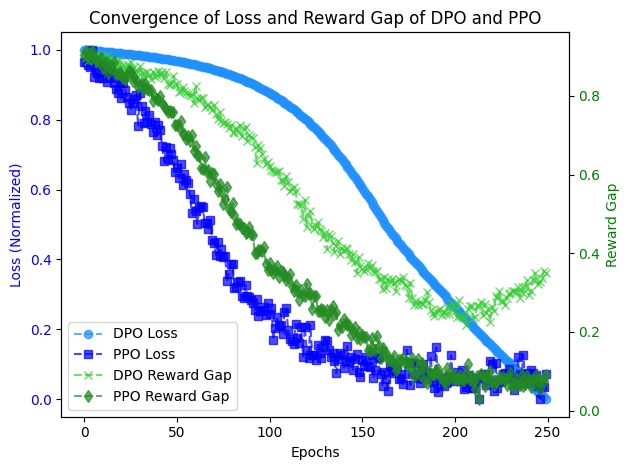

In [7]:
dpo_train_loss = np.array(dpo_train_loss)
normalized_dpo_loss = (dpo_train_loss - np.min(dpo_train_loss)) / (np.max(dpo_train_loss) - np.min(dpo_train_loss)) 

pg_train_loss = np.array(pg_train_loss)
normalized_pg_loss = (pg_train_loss - np.min(pg_train_loss)) / (np.max(pg_train_loss) - np.min(pg_train_loss))

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (Normalized)', color='blue')
l1 = ax1.plot(normalized_dpo_loss, label='DPO Loss', color='dodgerblue', alpha=0.7, linestyle='--', marker='o')
l2 = ax1.plot(normalized_pg_loss, label='PPO Loss', color='blue', alpha=0.7, linestyle='--', marker='s')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Reward Gap', color='green')
l3 = ax2.plot(dpo_reward_gap, label='DPO Reward Gap', color='limegreen', alpha=0.7, linestyle='--', marker='x')
l4 = ax2.plot(pg_reward_gap, label='PPO Reward Gap', color='forestgreen', alpha=0.7, linestyle='--', marker='d')
ax2.tick_params(axis='y', labelcolor='green')

lines = l1 + l2 + l3 + l4
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='lower left', fontsize=10)

plt.title('Convergence of Loss and Reward Gap of DPO and PPO')

fig.tight_layout()
plt.show()

**Repeated Experiments**

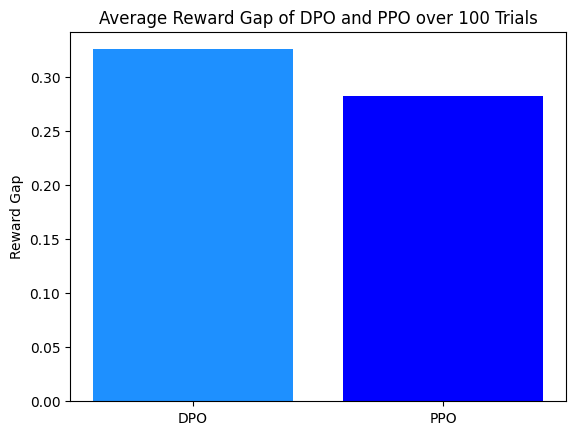

In [8]:
state_dim = 50
num_action = 10
hidden_dim = 64
pref_data_size = 100
reward_epochs = 50
policy_epochs = 200
batch_size = 64
learning_rate = 2e-4
beta = 1e-2
clip = 0.1

np.random.seed(2346)
torch.manual_seed(2346)
torch.cuda.manual_seed_all(2346)


last_dpo_reward = []
last_pg_reward = []
n_trials = 100

for _ in range(n_trials):
    true_reward_model = RewardModel(
        state_dim,
        num_action,
        is_env=True,
        hidden_dim=hidden_dim
    ).to(device)

    env = NeuralBandit(state_dim, num_action, true_reward_model)

    optimal_policy = env.optimal_policy
    optimal_reward = env.evaluate_policy(optimal_policy)

    ref_model = PolicyModel(
        state_dim,
        num_action,
        hidden_dim=hidden_dim,
        is_ref=True
    ).to(device)

    uniform_reward = env.evaluate_policy(ref_model)

    pref_data = collect_preference_data(env, pref_data_size)

    reward_model = RewardModel(
        state_dim,
        num_action,
        is_env=False,
        hidden_dim=hidden_dim
    ).to(device)

    reward_train_loss, reward_train_acc, reward_tau = reward_training(
        reward_model,
        pref_data,
        env,
        lr=learning_rate,
        batch_size=batch_size,
        epochs=reward_epochs,
    )

    dpo_policy = PolicyModel(
        state_dim,
        num_action,
        hidden_dim=hidden_dim,
        is_ref=False
    ).to(device)

    pg_policy = PolicyModel(
        state_dim,
        num_action,
        hidden_dim=hidden_dim,
        is_ref=False
    ).to(device)

    pg_policy.load_state_dict(dpo_policy.state_dict())

    dpo_train_loss, dpo_reward_gap = dpo(
        dpo_policy,
        ref_model,
        env,
        pref_data,
        lr=learning_rate,
        beta=beta,
        batch_size=batch_size,
        epochs=policy_epochs,
    )

    pg_train_loss, pg_reward_gap = pg(
        pg_policy,
        reward_model,
        ref_model,
        env,
        pref_data,
        lr=learning_rate,
        beta=beta,
        batch_size=batch_size,
        epochs=policy_epochs,
    )

    last_dpo_reward.append(dpo_reward_gap[-1])
    last_pg_reward.append(pg_reward_gap[-1])

dpo_reward, pg_reward = np.mean(last_dpo_reward), np.mean(last_pg_reward)

plt.figure()
plt.bar(['DPO', 'PPO'], [dpo_reward, pg_reward], color=['dodgerblue', 'blue'])
plt.ylabel('Reward Gap')
plt.title('Average Reward Gap of DPO and PPO over 100 Trials')
plt.show()

**Effect of Preference Data**

In [9]:
state_dim = 50
num_action = 10
hidden_dim = 64
reward_epochs = 50
policy_epochs = 100
batch_size = 64
learning_rate = 2e-4
beta = 1e-2
clip = 0.1

np.random.seed(2346)
torch.manual_seed(2346)
torch.cuda.manual_seed_all(2346)

dpo_reward = []
pg_reward = []
reward_tau_all = []
n_trials = 10

pref_data_sizes = [20, 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000]

for pref_data_size in pref_data_sizes:
    last_dpo_reward = []
    last_pg_reward = []
    reward_taus = []
    for _ in range(n_trials):
        true_reward_model = RewardModel(
            state_dim,
            num_action,
            is_env=True,
            hidden_dim=hidden_dim
        ).to(device)

        env = NeuralBandit(state_dim, num_action, true_reward_model)

        optimal_policy = env.optimal_policy
        optimal_reward = env.evaluate_policy(optimal_policy)

        ref_model = PolicyModel(
            state_dim,
            num_action,
            hidden_dim=hidden_dim,
            is_ref=True
        ).to(device)

        uniform_reward = env.evaluate_policy(ref_model)

        pref_data = collect_preference_data(env, pref_data_size)

        reward_model = RewardModel(
            state_dim,
            num_action,
            is_env=False,
            hidden_dim=hidden_dim
        ).to(device)

        reward_train_loss, reward_train_acc, reward_tau = reward_training(
            reward_model,
            pref_data,
            env,
            lr=learning_rate,
            batch_size=batch_size,
            epochs=reward_epochs,
        )

        reward_taus.append(reward_tau)

        dpo_policy = PolicyModel(
            state_dim,
            num_action,
            hidden_dim=hidden_dim,
            is_ref=False
        ).to(device)

        pg_policy = PolicyModel(
            state_dim,
            num_action,
            hidden_dim=hidden_dim,
            is_ref=False
        ).to(device)

        pg_policy.load_state_dict(dpo_policy.state_dict())

        dpo_train_loss, dpo_reward_gap = dpo(
            dpo_policy,
            ref_model,
            env,
            pref_data,
            lr=learning_rate,
            beta=beta,
            batch_size=batch_size,
            epochs=policy_epochs,
        )

        pg_train_loss, pg_reward_gap = pg(
            pg_policy,
            reward_model,
            ref_model,
            env,
            pref_data,
            lr=learning_rate,
            beta=beta,
            batch_size=batch_size,
            epochs=policy_epochs,
        )

        last_dpo_reward.append(dpo_reward_gap[-1])
        last_pg_reward.append(pg_reward_gap[-1])
    dpo_reward.append(np.mean(last_dpo_reward))
    pg_reward.append(np.mean(last_pg_reward))
    reward_tau_all.append(np.mean(reward_taus))

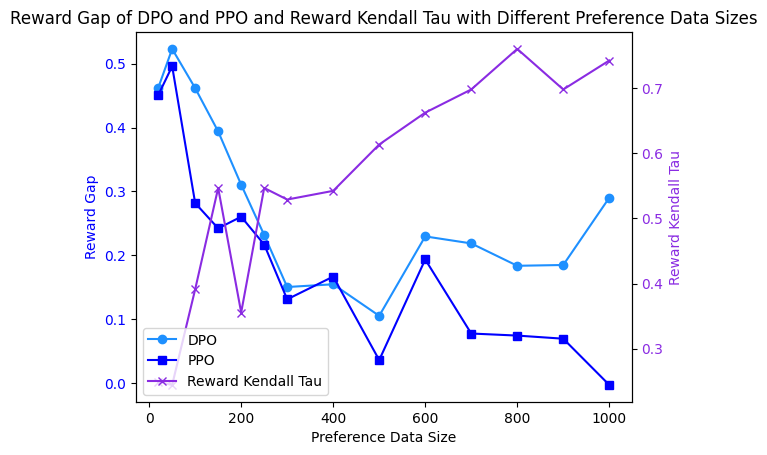

In [10]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Preference Data Size')
ax1.set_ylabel('Reward Gap', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
l1 = plt.plot(pref_data_sizes, dpo_reward, label='DPO', color='dodgerblue', marker='o')
l2 = plt.plot(pref_data_sizes, pg_reward, label='PPO', color='blue', marker='s')

ax2 = ax1.twinx()
ax2.set_ylabel('Reward Kendall Tau', color='blueviolet')
ax2.tick_params(axis='y', labelcolor='blueviolet')
l3 = plt.plot(pref_data_sizes, reward_tau_all, label='Reward Kendall Tau', color='blueviolet', marker='x')

lines = l1 + l2 + l3
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='lower left', fontsize=10)

plt.title('Reward Gap of DPO and PPO and Reward Kendall Tau with Different Preference Data Sizes')
plt.show()